This notebook takes the heght anomalies computed using Arctic DEM and estimate  a linear gridded time series using a 3-D Guassian interpolation. This is modeled after the Science Data Generation tutuorial from ICESAT-2 Hackweek 2020.

In [1]:
import h5py
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from utils import transform_coord
from utils import make_grid
from utils import mad_std
from utils import spatial_filter
from utils import interp2d
from utils import tiffread
from utils import binning
from scipy.ndimage.filters import generic_filter
import pandas as pd

In [2]:
!python ./interpgaus3d.py -h

usage: interpgaus3d.py [-h] [-b w e s n] [-d dx dy] [-t tmin tmax dt]
                       [-r radius] [-a alpha_d alpha_t] [-p epsg_num]
                       [-s n_sample] [-c dim thres max] [-v x y z t s]
                       ifile [ifile ...] ofile [ofile ...]

Spatio-temporal interpolation of irregular data

positional arguments:
  ifile               name of input file (h5-format)
  ofile               name of ouput file (h5-format)

optional arguments:
  -h, --help          show this help message and exit
  -b w e s n          bounding box for geograph. region (deg or m), optional
  -d dx dy            spatial resolution for grid (deg or km)
  -t tmin tmax dt     temporal resolution for grid (months)
  -r radius           search radius (km)
  -a alpha_d alpha_t  spatial and temporal corr. length (km and months)
  -p epsg_num         EPSG proj number (AnIS=3031, GrIS=3413)
  -s n_sample         sample every n:th point in dataset
  -c dim thres max    dim. of filter in km, si

In this case, This runs a 3-D Gaussain interpolation with grid size and search raidus of 3 km with a time step of a half a week. These variables (as well as the model paramenters a and c), can and should be experimented with(we should probably increase the dt given teh amount of daat we have).

In [9]:
!python ./interpgaus3d.py /home/jovyan/shared/data-crossovers/Arctic_DEM_dh_filtered.h5 /home/jovyan/shared/data-crossovers/AD_filtered_data_cube.h5 -d 3 3 -t 2018.8 2020.25 0.125 \
-r 3 -a 10 0.125 -p 32607 -c 100 3 10 -v lon lat dh t_year dummy -s 1

parameters:
('ifile', ['/home/jovyan/shared/data-crossovers/Arctic_DEM_dh_filtered.h5'])
('ofile', ['/home/jovyan/shared/data-crossovers/AD_filtered_data_cube.h5'])
('bbox', [None])
('dxy', [3.0, 3.0])
('time', [2018.8, 2020.25, 0.125])
('radius', [3.0])
('alpha', [10.0, 0.125])
('proj', ['32607'])
('n_sample', [1])
('filter', [100.0, 3.0, 10.0])
('vnames', ['lon', 'lat', 'dh', 't_year', 'dummy'])
-> reading data ...
-> cleaning data ...
-> creating kdtree ...
-> interpolating data ...
-> saving predictions to file...


In [10]:
f = h5py.File('/home/jovyan/shared/data-crossovers/Arctic_DEM_dh.h5', 'r')

In [12]:
!h5ls /home/jovyan/shared/data-crossovers/AD_filtered_data_cube.h5

X                        Dataset {17, 19}
Y                        Dataset {17, 19}
Z_nobs                   Dataset {141, 17, 19}
Z_pred                   Dataset {141, 17, 19}
Z_rmse                   Dataset {141, 17, 19}
epsg                     Dataset {SCALAR}
time                     Dataset {141}


In [14]:
#read in interpolated data
with h5py.File('/home/jovyan/shared/data-crossovers/AD_filtered_data_cube.h5','r') as f_c:
    Xi = f_c['X'][:]
    Yi = f_c['Y'][:]
    ti = f_c['time'][:]
    Zi = f_c['Z_pred'][:]

In [15]:
hi = np.nanmean(np.nanmean(Zi,1),1) #mean elevation chnage for each time step

Text(0, 0.5, 'Elevation residuals (m)')

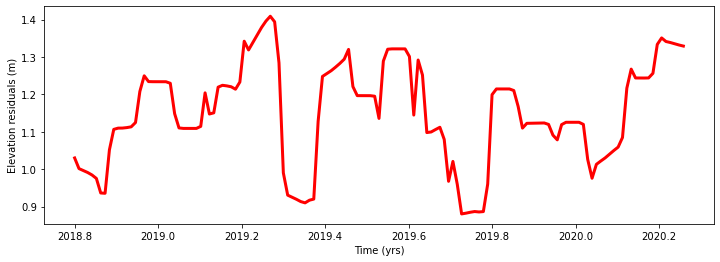

In [16]:
#plot time series using mena values
plt.figure(figsize=(12,4))
plt.plot(ti, hi,'r',linewidth=3,label='interpolated')
plt.xlabel('Time (yrs)')
plt.ylabel('Elevation residuals (m)')

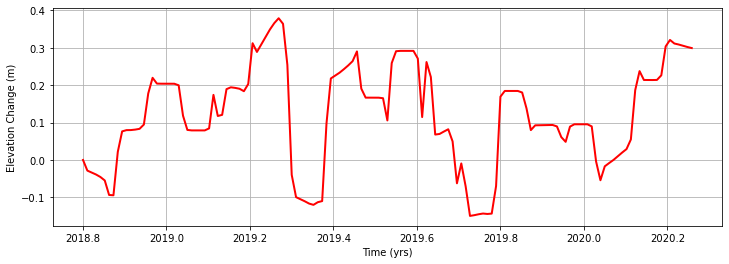

In [17]:
#conver time series ot elevation  change with respect to the start date
plt.figure(figsize=(12,4))
plt.plot(ti, hi - hi[0],'r',linewidth=2)
plt.ylabel('Elevation Change (m)')
plt.xlabel('Time (yrs)')
plt.grid()
plt.savefig('time_series_3km_v2.png')

In [18]:
#estimate dh/dt (assuming it's linear)
nt,nx,ny = Zi.shape
rate = np.zeros((nx,ny))*np.nan
for i in range(nx):
    for j in range(ny):
        dh = Zi[:,i,j]
        if np.any(np.isnan(dh)):continue
        rate[i,j] = np.polyfit(ti,Zi[:,i,j],1)[0]
Zf = generic_filter(rate.copy(), np.nanmean, 2) #smooth the data - filtering parameter can be messed with

/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/ndimage/filters.py:1447: RuntimeWarning: Mean of empty slice
  cval, origins, extra_arguments, extra_keywords)


Trend: 0.0 (m/yr)


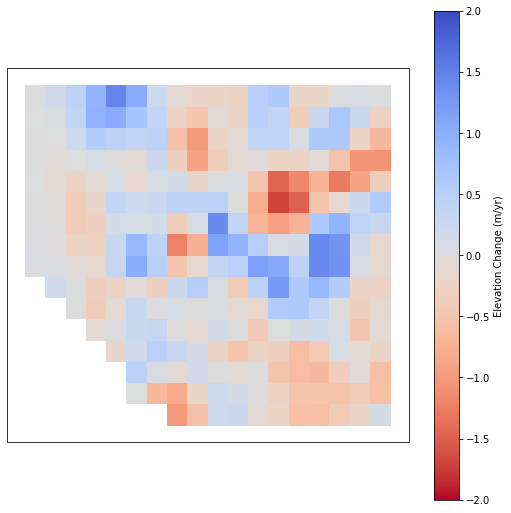

In [19]:
#plot spatial distribution of dh/dt
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.UTM(7)) #or UTM(7)
im = plt.pcolormesh(Xi, Yi, Zf, transform=ccrs.UTM(7), cmap='coolwarm_r',vmin=-1.5,vmax=0.5)

plt.colorbar(label='Elevation Change (m/yr)')
plt.clim([-2, 2])
print('Trend:',np.around(np.nanmean(Zf),1),'(m/yr)')
plt.savefig('gridded_ts_3km_filteted.png')


Help on function generic_filter in module scipy.ndimage.filters:

generic_filter(input, function, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0, extra_arguments=(), extra_keywords=None)
    Calculate a multi-dimensional filter using the given function.
    
    At each element the provided function is called. The input values
    within the filter footprint at that element are passed to the function
    as a 1D array of double values.
    
    Parameters
    ----------
    input : array_like
        The input array.
    function : {callable, scipy.LowLevelCallable}
        Function to apply at each element.
    size : scalar or tuple, optional
        See footprint, below. Ignored if footprint is given.
    footprint : array, optional
        Either `size` or `footprint` must be defined.  `size` gives
        the shape that is taken from the input array, at every element
        position, to define the input to the filter function.
        `footprint` is a 